In [7]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2

In [29]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [11]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config_xenium_multiplex.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config_xenium_multiplex.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config_xenium_multiplex.yaml']

In [12]:
xenium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_size': 30,
        'decoder_dims': (256, 256, 256,)
    },
    'learner_kwargs': {
        'scale': 1.,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 5000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 200,
#         'save_dir': chkpt_dir       
    },
}

In [13]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config_xenium_multiplex.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/{case}_xenium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [16]:
xenium_config['sections'] = config
xenium_config['train_kwargs']['save_dir'] = chkpt_dir
xenium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '4000iter.pt')

In [17]:
mushroom = Mushroom.from_config(xenium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 377 channels
INFO:root:6 sections detected: ['s0', 's3', 's4', 's7', 's8', 's11']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s3
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s11
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [18]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's7'}>, <Axes: title={'center': 's8'}>,
        <Axes: title={'center': 's11'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

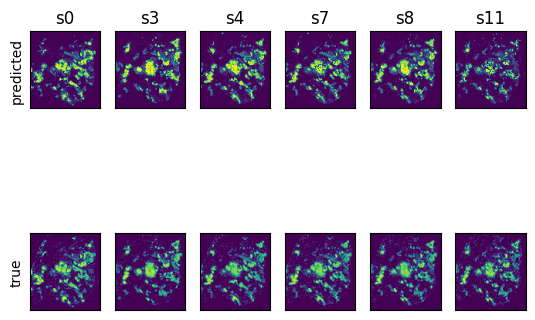

In [19]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's7'}>, <Axes: title={'center': 's8'}>,
        <Axes: title={'center': 's11'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

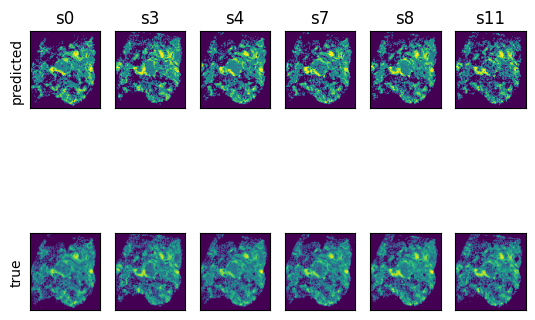

In [20]:
mushroom.display_predicted_pixels(channel='PTPRC')

In [28]:
cluster_ids = mushroom.cluster_ids.cpu().detach().numpy()

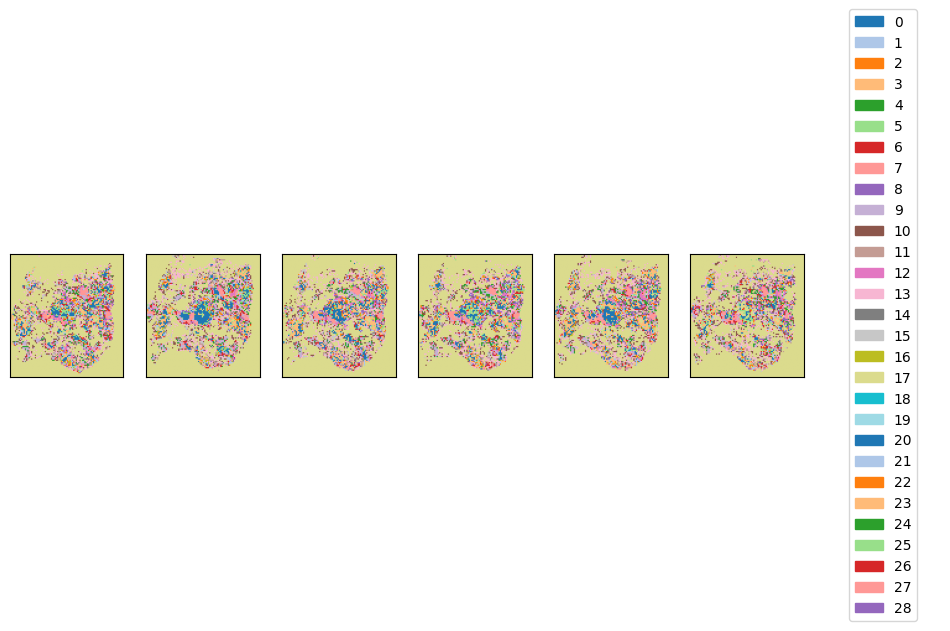

In [30]:
vis_utils.display_clusters(cluster_ids)

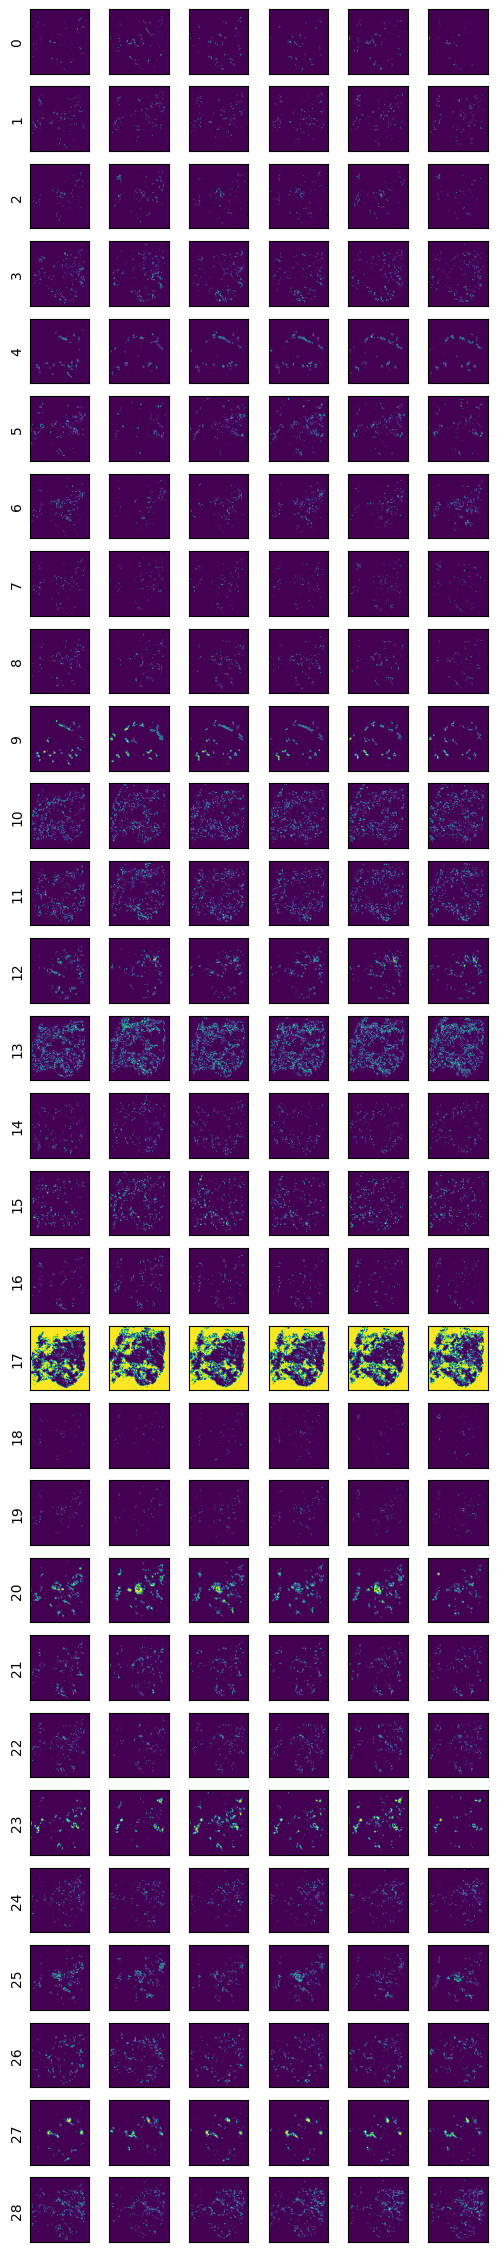

In [31]:
utils.display_cluster_probs(mushroom.cluster_probs)

In [ ]:
# s0 0
# s3 35
# s4 40
# s7 75
# s8 80
# s11 115

In [61]:
section_positions = (np.asarray([0, 35, 40, 75, 80, 115]) * .1).astype(int)
print(section_positions)
cluster_volume = utils.get_interpolated_volume(cluster_ids, section_positions)
cluster_volume.shape

[ 0  3  4  7  8 11]


(11, 100, 92)

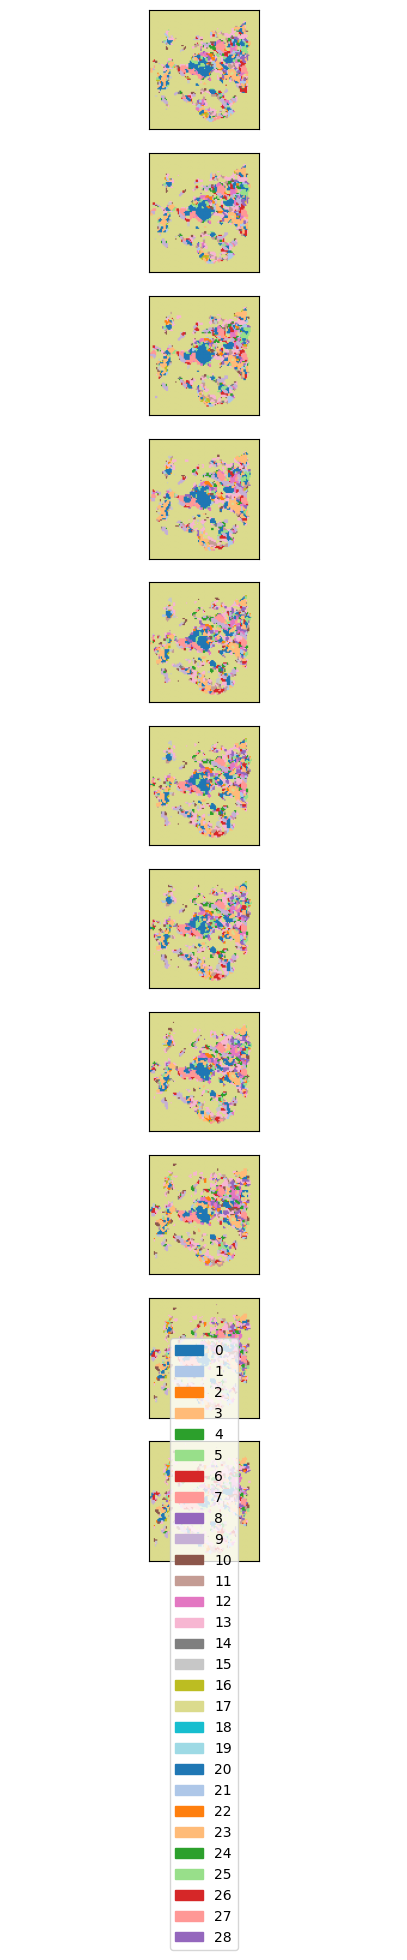

In [62]:
vis_utils.display_clusters(cluster_volume, horizontal=False)

In [63]:
probs = rearrange(mushroom.cluster_probs, 'n c h w -> c n h w').cpu().detach().numpy()
probs_volume = utils.get_interpolated_volume(probs, section_positions, method='linear')

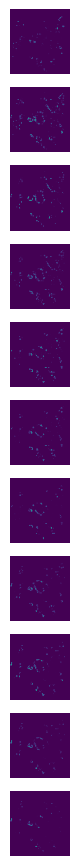

In [64]:
fig, axs = plt.subplots(nrows=probs_volume.shape[1], figsize=(5, probs_volume.shape[1]))
for i, ax in enumerate(axs):
    ax.imshow(probs_volume[0, i])
    ax.axis('off')
    

In [65]:
out_fp = os.path.join(out_dir, 'outputs.npy')
np.save(out_fp, {
    'cluster_ids': cluster_ids,
    'cluster_probs': probs,
    'cluster_volume': cluster_volume,
    'section_positions': section_positions
})


In [55]:
out_fp

'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1_xenium/outputs/outputs.npy'

In [57]:
np.load(out_fp, allow_pickle=True)

array({'cluster_ids': array([[[17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        ...,
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17]],

       [[17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        ...,
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17]],

       [[17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        ...,
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17]],

       [[17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        ...,
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..., 17, 17, 17],
        [17, 17, 17, ..

In [49]:
[g for g in mushroom.learner.channels if 'GBN' in g]

[]

In [50]:
gene_sets = {
    'T cell/NK': ['CD3D', 'CD4', 'FOXP3', 'GZMB'],
    'Macrophage': ['CD68', 'CD163'],
    'B cell': ['MS4A1'],
    'Fibroblast': ['ACTA2'],
    'Epithelial': ['EPCAM', 'KRT7'],
    'Endothelial': ['PECAM1']
}

for k, gs in gene_sets.items():
    for g in gs:
        if g not in mushroom.learner.channels:
            print(k, g)

In [39]:
cluster_df = mushroom.get_cluster_intensities(cluster_ids)
cluster_df

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,ADH1C,...,TRAC,TREM2,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF
0,0.187254,0.227388,0.070745,0.387721,0.841536,0.787987,0.533255,0.435611,0.368535,0.188652,...,0.523059,0.878008,0.336001,0.601947,0.167168,0.302588,0.770973,0.634362,0.280044,0.270952
1,-0.075155,0.038828,0.241195,0.326992,0.467704,0.412644,0.382580,0.132220,0.497619,0.092491,...,0.381426,0.389175,0.054632,0.136315,0.000340,-0.055022,0.605077,0.714870,0.146074,0.502236
2,0.180587,0.141901,0.120555,0.414109,0.772866,0.471697,0.685243,0.242958,0.524276,0.075721,...,0.251725,0.713695,0.230623,0.635057,0.110671,0.263001,0.848079,0.605728,0.174844,0.458269
3,-0.057128,0.075776,0.111479,0.254259,0.499840,0.607665,0.172884,0.165866,0.256483,0.221458,...,0.604266,0.296586,0.114264,0.032700,0.007339,-0.039471,0.621249,0.826138,0.238318,0.223133
4,-0.002253,0.287250,0.286000,0.715457,0.657706,0.550991,0.504492,0.197625,0.401162,0.494458,...,0.443014,0.191258,0.216126,0.063117,0.117488,0.046847,0.401748,0.726587,0.694644,0.325353
5,0.477133,0.464558,0.014421,0.227495,0.685016,0.328298,0.476168,0.507393,0.215084,0.441111,...,0.105549,0.640299,0.545823,0.622501,0.444260,0.373129,0.571543,0.252252,0.187436,0.108562
6,0.154416,0.099725,-0.076874,0.235885,0.560725,0.233967,0.366479,0.144946,0.166557,0.044177,...,0.097534,0.468866,0.177284,0.511509,0.087062,0.214119,0.580742,0.313396,0.059087,0.127742
7,-0.026820,0.055452,0.013666,0.359008,0.632779,0.576001,0.321909,0.236095,0.338219,0.047553,...,0.413469,0.695913,0.131977,0.368131,0.038239,0.052471,0.689114,0.754492,0.157614,0.301012
8,0.196927,0.155705,-0.128000,0.321754,0.798558,0.549821,0.427664,0.323366,0.181500,0.073567,...,0.300556,0.825356,0.264366,0.664899,0.123189,0.293838,0.764779,0.546502,0.149171,0.118917
9,0.087610,0.467654,0.363922,0.899853,0.804236,0.809113,0.651491,0.348871,0.493565,0.653784,...,0.570689,0.350416,0.371835,0.127827,0.209809,0.135777,0.399909,0.701245,0.913860,0.381133


In [52]:
score_df = {}
for k, gs in gene_sets.items():
    score_df[k] = cluster_df[gs].values.sum(1)
score_df = pd.DataFrame.from_dict(score_df)
score_df.index = cluster_df.index.to_list()
score_df

,T cell/NK,Macrophage,B cell,Fibroblast,Epithelial,Endothelial
0,2.528226,1.670187,2.739132e-01,0.387721,1.186375,0.676070
1,1.277671,1.273658,4.945145e-02,0.326992,0.239582,0.686084
2,1.242695,1.295603,4.158613e-02,0.414109,1.287377,0.669594
3,2.109440,1.588790,2.248168e-01,0.254259,0.029642,0.621867
4,1.349687,1.203719,2.224475e-01,0.715457,0.493032,0.660822
5,0.763030,0.785636,1.549286e-01,0.227495,1.290459,0.294640
6,0.582414,0.808491,2.596907e-03,0.235885,1.037349,0.329737
7,1.730292,1.539987,5.771746e-02,0.359008,0.722004,0.652343
8,1.616986,1.422317,9.180656e-02,0.321754,1.319655,0.499891
9,1.972013,1.351898,4.119461e-01,0.899853,0.810243,0.750752


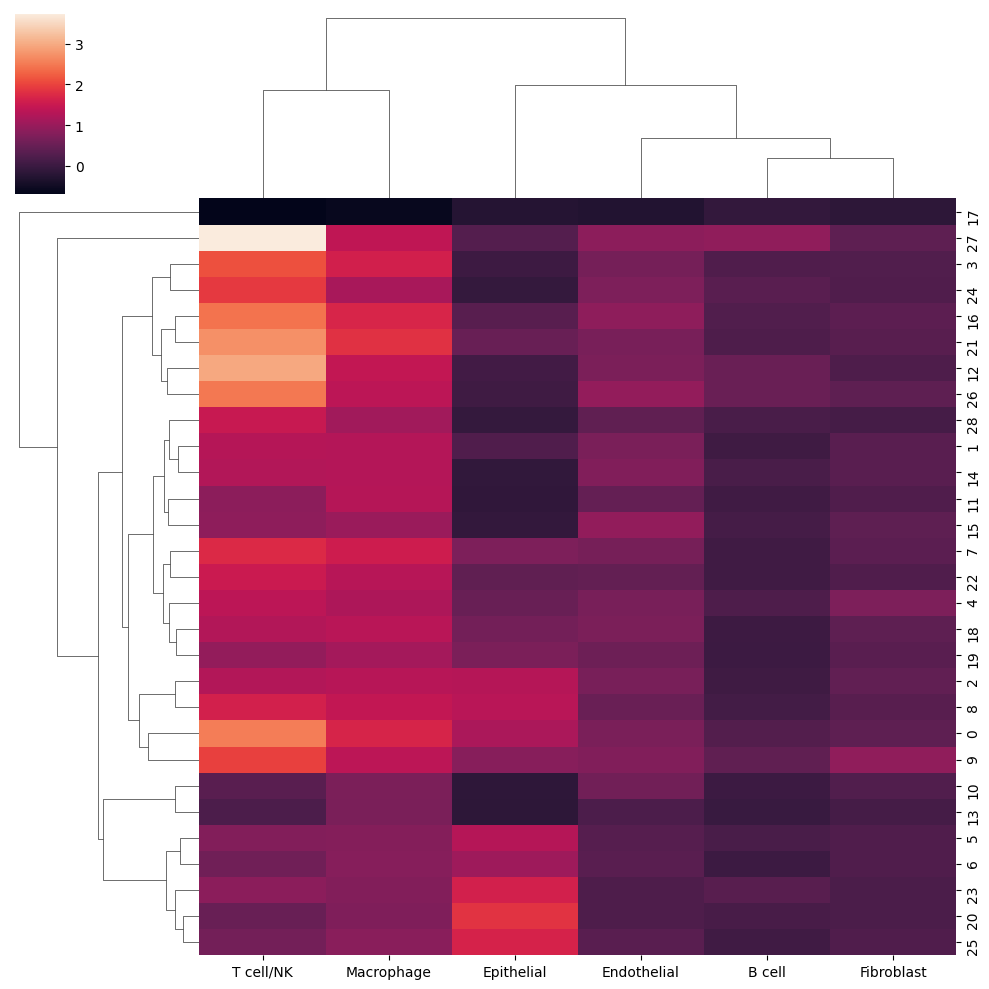

In [54]:
sns.clustermap(score_df)

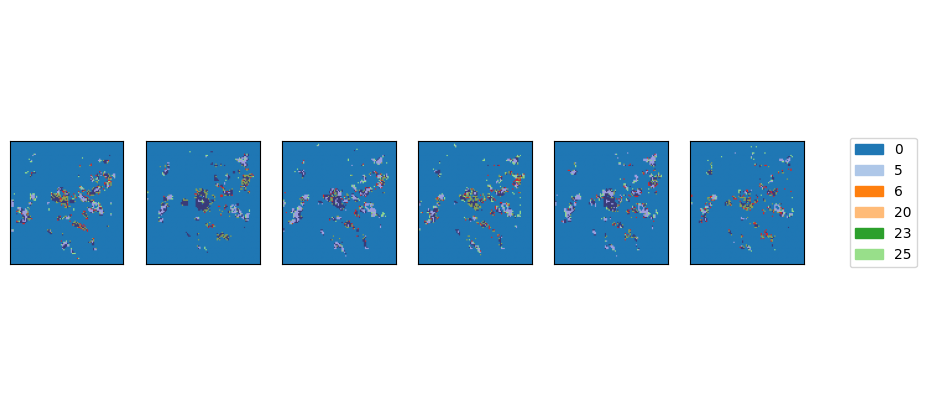

In [60]:
mapping = {i:i for i in np.unique(cluster_ids)}
mapping.update({i:0 for i in np.unique(cluster_ids) if i not in [5, 6, 23, 20, 25]})
neigh_ids = np.vectorize(mapping.get)(cluster_ids)
vis_utils.display_clusters(neigh_ids, cmap=sns.color_palette('tab20') + sns.color_palette('tab20b'))

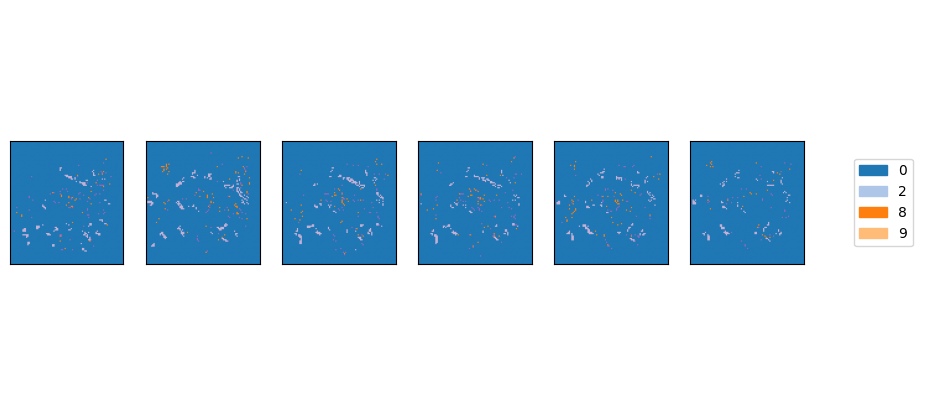

In [66]:
mapping = {i:i for i in np.unique(cluster_ids)}
mapping.update({i:0 for i in np.unique(cluster_ids) if i not in [9, 0, 8, 2]})
neigh_ids = np.vectorize(mapping.get)(cluster_ids)
vis_utils.display_clusters(neigh_ids, cmap=sns.color_palette('tab20') + sns.color_palette('tab20b'))

In [59]:
neigh_ids

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   